In [ ]:
# BERT-based Named Entity Recognition (NER) on CoNLL-2003 Dataset
# =============================================================

# Install required packages
!pip install transformers datasets evaluate seqeval torch tqdm matplotlib pandas seaborn -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 19.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 37.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 53.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 8.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.6 MB/s eta 0:00:00
  

In [ ]:
import torch
from torch.utils.data import DataLoader
from transformers import (
    BertTokenizerFast,
    BertForTokenClassification,
    DataCollatorForTokenClassification,
    get_linear_schedule_with_warmup
)
from torch.optim import AdamW
from datasets import load_dataset
from evaluate import load
import numpy as np
from tqdm.notebook import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import random
import time
from IPython.display import display, HTML

In [ ]:
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

# Check device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [ ]:
# 1. Data Loading and Exploration
# ==============================
print("\n==== Data Loading and Exploration ====")

# Load dataset and metric
dataset = load_dataset("conll2003")
metric = load("seqeval")

# Basic dataset info
print("\nDataset splits:")
for split in dataset.keys():
    print(f"- {split}: {dataset[split].num_rows} examples")

# Examine data structure
print("\nDataset features:", dataset["train"].features)



==== Data Loading and Exploration ====


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/12.3k [00:00<?, ?B/s]

conll2003.py:   0%|          | 0.00/9.57k [00:00<?, ?B/s]

The repository for conll2003 contains custom code which must be executed to correctly load the dataset. You can inspect the repository content at https://hf.co/datasets/conll2003.
You can avoid this prompt in future by passing the argument `trust_remote_code=True`.

Do you wish to run the custom code? [y/N] y


Generating train split:   0%|          | 0/14041 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/3250 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/3453 [00:00<?, ? examples/s]


Dataset splits:
- train: 14041 examples
- validation: 3250 examples
- test: 3453 examples

Dataset features: {'id': Value(dtype='string', id=None), 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None), 'pos_tags': Sequence(feature=ClassLabel(names=['"', "''", '#', '$', '(', ')', ',', '.', ':', '``', 'CC', 'CD', 'DT', 'EX', 'FW', 'IN', 'JJ', 'JJR', 'JJS', 'LS', 'MD', 'NN', 'NNP', 'NNPS', 'NNS', 'NN|SYM', 'PDT', 'POS', 'PRP', 'PRP$', 'RB', 'RBR', 'RBS', 'RP', 'SYM', 'TO', 'UH', 'VB', 'VBD', 'VBG', 'VBN', 'VBP', 'VBZ', 'WDT', 'WP', 'WP$', 'WRB'], id=None), length=-1, id=None), 'chunk_tags': Sequence(feature=ClassLabel(names=['O', 'B-ADJP', 'I-ADJP', 'B-ADVP', 'I-ADVP', 'B-CONJP', 'I-CONJP', 'B-INTJ', 'I-INTJ', 'B-LST', 'I-LST', 'B-NP', 'I-NP', 'B-PP', 'I-PP', 'B-PRT', 'I-PRT', 'B-SBAR', 'I-SBAR', 'B-UCP', 'I-UCP', 'B-VP', 'I-VP'], id=None), length=-1, id=None), 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LO

In [ ]:
# 2. Data Preprocessing
# ====================
print("\n==== Data Preprocessing ====")

# Initialize tokenizer
tokenizer = BertTokenizerFast.from_pretrained("bert-base-cased")

# Preprocess function to align labels with tokens
def tokenize_and_align_labels(examples):
    tokenized_inputs = tokenizer(
        examples["tokens"],
        truncation=True,
        is_split_into_words=True,
        padding="max_length",
        max_length=128,
        return_tensors="pt"
    )

    labels = []
    for i, label in enumerate(examples["ner_tags"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []

        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)  # Special tokens get -100
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])  # First token of word
            else:
                label_ids.append(-100)  # Subsequent tokens of word get -100

            previous_word_idx = word_idx

        labels.append(label_ids)

    tokenized_inputs["labels"] = labels
    return tokenized_inputs

print("Tokenizing dataset...")
start_time = time.time()

# Tokenize dataset
tokenized_datasets = dataset.map(
    tokenize_and_align_labels,
    batched=True,
    remove_columns=dataset["train"].column_names
)
tokenization_time = time.time() - start_time
print(f"Tokenization completed in {tokenization_time:.2f} seconds")

# Show tokenization example
print("\nTokenization example:")
example_tokens = dataset["train"][example_idx]["tokens"][:10]
example_tags = [label_list[idx] for idx in dataset["train"][example_idx]["ner_tags"][:10]]

print("Original:")
for token, tag in zip(example_tokens, example_tags):
    print(f"{token:<15} -> {tag}")

print("\nTokenized:")
tokenized_example = tokenizer(example_tokens, is_split_into_words=True)
tokenized_words = tokenizer.convert_ids_to_tokens(tokenized_example.input_ids)

for token in tokenized_words:
    print(token)


==== Data Preprocessing ====


tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

Tokenizing dataset...


Map:   0%|          | 0/14041 [00:00<?, ? examples/s]

Map:   0%|          | 0/3250 [00:00<?, ? examples/s]

Map:   0%|          | 0/3453 [00:00<?, ? examples/s]

Tokenization completed in 5.76 seconds

Tokenization example:
Original:
FRANKFURT       -> B-LOC
1996-08-22      -> O

Tokenized:
[CLS]
F
##RA
##N
##K
##F
##UR
##T
1996
-
08
-
22
[SEP]


In [ ]:
# 3. Model Setup
# =============
print("\n==== Model Setup ====")

# Create data collator
data_collator = DataCollatorForTokenClassification(tokenizer)

# Create DataLoaders
batch_size = 16
print(f"Using batch size: {batch_size}")

train_dataloader = DataLoader(
    tokenized_datasets["train"],
    shuffle=True,
    collate_fn=data_collator,
    batch_size=batch_size
)

val_dataloader = DataLoader(
    tokenized_datasets["validation"],
    collate_fn=data_collator,
    batch_size=batch_size
)

test_dataloader = DataLoader(
    tokenized_datasets["test"],
    collate_fn=data_collator,
    batch_size=batch_size
)


==== Model Setup ====
Using batch size: 16


In [ ]:
# Initialize model
print("\nInitializing BERT model for token classification...")

model = BertForTokenClassification.from_pretrained(
    "bert-base-cased",
    num_labels=len(label_list),
    id2label={i: label for i, label in enumerate(label_list)},
    label2id={label: i for i, label in enumerate(label_list)}
).to(device)

# Print model architecture
print("\nModel architecture:")
print(model.__class__.__name__)
total_params = sum(p.numel() for p in model.parameters())
trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Non-trainable parameters: {total_params - trainable_params:,}")



Initializing BERT model for token classification...


Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of BertForTokenClassification were not initialized from the model checkpoint at bert-base-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



Model architecture:
BertForTokenClassification
Total parameters: 107,726,601
Trainable parameters: 107,726,601
Non-trainable parameters: 0


In [ ]:
# 4. Training Setup
# ================
print("\n==== Training Setup ====")

# Hyperparameters
learning_rate = 2e-5
epochs = 5
weight_decay = 0.01
warmup_steps = 0

print(f"Learning rate: {learning_rate}")
print(f"Epochs: {epochs}")
print(f"Weight decay: {weight_decay}")
print(f"Warmup steps: {warmup_steps}")

# Optimizer and scheduler
optimizer = AdamW(
    model.parameters(),
    lr=learning_rate,
    weight_decay=weight_decay
)

total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=warmup_steps,
    num_training_steps=total_steps
)


==== Training Setup ====
Learning rate: 2e-05
Epochs: 5
Weight decay: 0.01
Warmup steps: 0


In [ ]:
# 5. Training Loop
# ==============
print("\n==== Training Loop ====")

# Helper function for evaluation
def evaluate(dataloader, desc="Evaluating"):
    model.eval()
    predictions, true_labels = [], []

    for batch in tqdm(dataloader, desc=desc):
        batch = {k: v.to(device) for k, v in batch.items()}

        with torch.no_grad():
            outputs = model(**batch)
            logits = outputs.logits
            batch_preds = torch.argmax(logits, dim=-1).cpu().numpy()
            batch_labels = batch["labels"].cpu().numpy()

        for preds, labels in zip(batch_preds, batch_labels):
            # Filter out ignored index (-100)
            true_indices = [i for i, l in enumerate(labels) if l != -100]
            true_labels.append([label_list[labels[i]] for i in true_indices])
            predictions.append([label_list[preds[i]] for i in true_indices])

    results = metric.compute(predictions=predictions, references=true_labels)
    return results, predictions, true_labels


# Store metrics for plotting
train_losses = []
val_f1_scores = []

print("\nStarting training...")
start_training_time = time.time()

for epoch in range(epochs):
    epoch_start_time = time.time()

    # Training
    model.train()
    total_loss = 0

    for batch in tqdm(train_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Training]"):
        batch = {k: v.to(device) for k, v in batch.items()}

        outputs = model(**batch)
        loss = outputs.loss
        total_loss += loss.item()

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    avg_train_loss = total_loss / len(train_dataloader)
    train_losses.append(avg_train_loss)

    # Validation
    val_results, _, _ = evaluate(val_dataloader, desc=f"Epoch {epoch+1}/{epochs} [Validation]")
    val_f1_scores.append(val_results["overall_f1"])

    epoch_time = time.time() - epoch_start_time

    # Print metrics
    print(f"\nEpoch {epoch+1}/{epochs} completed in {epoch_time:.2f} seconds")
    print(f"Training Loss: {avg_train_loss:.4f}")
    print(f"Validation F1: {val_results['overall_f1']:.4f}")
    print(f"Validation Precision: {val_results['overall_precision']:.4f}")
    print(f"Validation Recall: {val_results['overall_recall']:.4f}")

total_training_time = time.time() - start_training_time
print(f"\nTraining completed in {total_training_time:.2f} seconds ({total_training_time/60:.2f} minutes)")



==== Training Loop ====

Starting training...


Epoch 1/5 [Training]:   0%|          | 0/878 [00:00<?, ?it/s]

Epoch 1/5 [Validation]:   0%|          | 0/204 [00:00<?, ?it/s]


Epoch 1/5 completed in 321.38 seconds
Training Loss: 0.0175
Validation F1: 0.9459
Validation Precision: 0.9447
Validation Recall: 0.9471


Epoch 2/5 [Training]:   0%|          | 0/878 [00:00<?, ?it/s]

Epoch 2/5 [Validation]:   0%|          | 0/204 [00:00<?, ?it/s]


Epoch 2/5 completed in 321.55 seconds
Training Loss: 0.0100
Validation F1: 0.9463
Validation Precision: 0.9410
Validation Recall: 0.9517


Epoch 3/5 [Training]:   0%|          | 0/878 [00:00<?, ?it/s]

Epoch 3/5 [Validation]:   0%|          | 0/204 [00:00<?, ?it/s]


Epoch 3/5 completed in 321.24 seconds
Training Loss: 0.0054
Validation F1: 0.9471
Validation Precision: 0.9435
Validation Recall: 0.9506


Epoch 4/5 [Training]:   0%|          | 0/878 [00:00<?, ?it/s]

Epoch 4/5 [Validation]:   0%|          | 0/204 [00:00<?, ?it/s]


Epoch 4/5 completed in 322.18 seconds
Training Loss: 0.0027
Validation F1: 0.9497
Validation Precision: 0.9462
Validation Recall: 0.9533


Epoch 5/5 [Training]:   0%|          | 0/878 [00:00<?, ?it/s]

Epoch 5/5 [Validation]:   0%|          | 0/204 [00:00<?, ?it/s]


Epoch 5/5 completed in 321.19 seconds
Training Loss: 0.0016
Validation F1: 0.9493
Validation Precision: 0.9452
Validation Recall: 0.9535

Training completed in 1607.54 seconds (26.79 minutes)


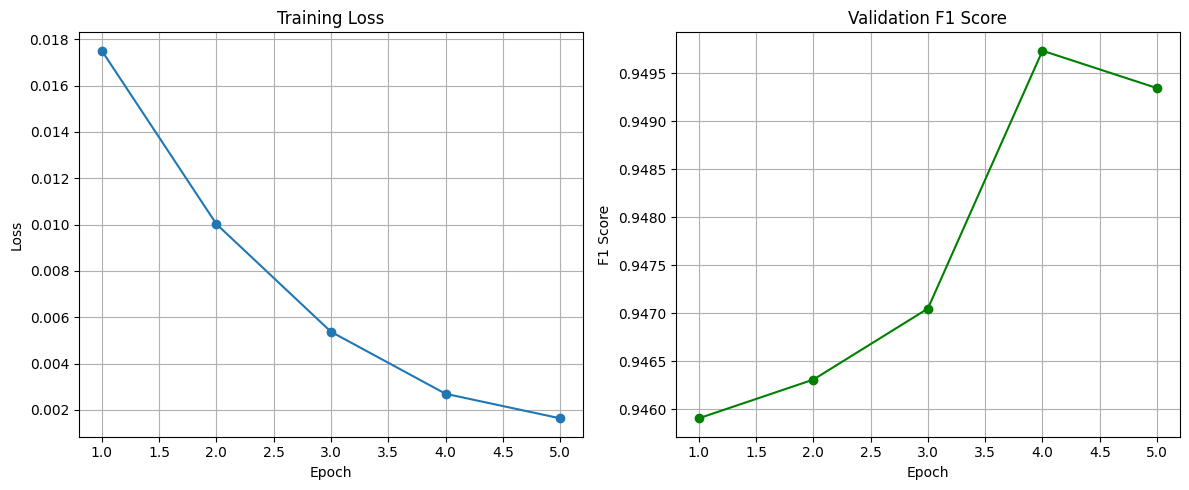

In [ ]:
# Plot training progress
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, epochs + 1), train_losses, marker='o')
plt.title("Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, epochs + 1), val_f1_scores, marker='o', color='green')
plt.title("Validation F1 Score")
plt.xlabel("Epoch")
plt.ylabel("F1 Score")
plt.grid(True)

plt.tight_layout()
plt.show()

In [ ]:
# 6. Test Evaluation and Analysis
# ==============================
print("\n==== Test Evaluation and Analysis ====")

print("Evaluating on test set...")
test_results, test_predictions, test_true_labels = evaluate(test_dataloader, "Testing")

# Print overall metrics
print("\nTest Results:")
print(f"Accuracy: {test_results['overall_accuracy']:.4f}")
print(f"Precision: {test_results['overall_precision']:.4f}")
print(f"Recall: {test_results['overall_recall']:.4f}")
print(f"F1 Score: {test_results['overall_f1']:.4f}")

# Print per-entity metrics
print("\nPer-Entity Type Metrics:")
entity_results = {}
for key in sorted(test_results.keys()):
    if key not in ['overall_accuracy', 'overall_precision', 'overall_recall', 'overall_f1']:
        entity_results[key] = {
            'precision': test_results[key]['precision'],
            'recall': test_results[key]['recall'],
            'f1': test_results[key]['f1'],
            'number': test_results[key]['number']
        }
        print(f"{key}:")
        print(f"  Precision: {test_results[key]['precision']:.4f}")
        print(f"  Recall: {test_results[key]['recall']:.4f}")
        print(f"  F1: {test_results[key]['f1']:.4f}")
        print(f"  Support: {test_results[key]['number']} entities")


==== Test Evaluation and Analysis ====
Evaluating on test set...


Testing:   0%|          | 0/216 [00:00<?, ?it/s]


Test Results:
Accuracy: 0.9835
Precision: 0.9096
Recall: 0.9258
F1 Score: 0.9176

Per-Entity Type Metrics:
LOC:
  Precision: 0.9397
  Recall: 0.9358
  F1: 0.9377
  Support: 1666 entities
MISC:
  Precision: 0.7726
  Recall: 0.8276
  F1: 0.7992
  Support: 702 entities
ORG:
  Precision: 0.8847
  Recall: 0.9241
  F1: 0.9040
  Support: 1661 entities
PER:
  Precision: 0.9700
  Recall: 0.9598
  F1: 0.9648
  Support: 1615 entities


In [ ]:
# 7. Error Analysis
# ===============
print("\n==== Error Analysis ====")

model.eval()
misclassified_examples = []
test_set_indices = []
batch_idx = 0

for batch in tqdm(test_dataloader, desc="Collecting misclassified examples"):
    batch = {k: v.to(device) for k, v in batch.items()}

    with torch.no_grad():
        outputs = model(**batch)
        logits = outputs.logits
        batch_predictions = torch.argmax(logits, dim=-1)
        batch_labels = batch["labels"]

    # Process each example in the batch
    for i in range(len(batch_predictions)):
        # Get the input IDs
        input_ids = batch["input_ids"][i].cpu().numpy()
        tokens = tokenizer.convert_ids_to_tokens(input_ids)
        token_preds = batch_predictions[i].cpu().numpy()
        token_labels = batch_labels[i].cpu().numpy()

        # Collect misclassified tokens
        sample_misclassified = []
        sample_index = batch_idx * batch_size + i

        for j, (token, pred, label) in enumerate(zip(tokens, token_preds, token_labels)):
            if label != -100:  # Skip special tokens and subtokens
                pred_label = label_list[pred]
                true_label = label_list[label]

                if pred_label != true_label:
                    sample_misclassified.append({
                        'token': token,
                        'pred': pred_label,
                        'true': true_label
                    })

        if sample_misclassified:
            misclassified_examples.append(sample_misclassified)
            test_set_indices.append(sample_index)

    batch_idx += 1

print(f"\nFound {len(misclassified_examples)} examples with misclassifications")

# Analyze error types
error_types = defaultdict(int)
error_tokens = defaultdict(list)

for example in misclassified_examples:
    for item in example:
        error_type = (item['true'], item['pred'])
        error_types[error_type] += 1
        error_tokens[error_type].append(item['token'])

# Print most common error types
print("\nMost common error types:")
for (true, pred), count in sorted(error_types.items(), key=lambda x: x[1], reverse=True)[:10]:
    tokens_sample = error_tokens[(true, pred)][:3]  # Show a few example tokens
    print(f"TRUE: {true:<6} -> PRED: {pred:<6}: {count} occurrences")
    print(f"  Example tokens: {', '.join(tokens_sample)}")


==== Error Analysis ====



Found 468 examples with misclassifications

Most common error types:
TRUE: O      -> PRED: I-MISC: 73 occurrences
  Example tokens: C, G, C
TRUE: O      -> PRED: B-MISC: 56 occurrences
  Example tokens: Group, AU, EA
TRUE: O      -> PRED: B-ORG : 48 occurrences
  Example tokens: Con, NFC, G
TRUE: B-LOC  -> PRED: B-ORG : 46 occurrences
  Example tokens: J, J, MAC
TRUE: O      -> PRED: I-ORG : 41 occurrences
  Example tokens: of, G, Global
TRUE: B-MISC -> PRED: B-ORG : 40 occurrences
  Example tokens: En, AR, X
TRUE: B-ORG  -> PRED: B-LOC : 38 occurrences
  Example tokens: NY, Arizona, Nebraska
TRUE: B-PER  -> PRED: B-ORG : 33 occurrences
  Example tokens: Bit, Bit, Bit
TRUE: B-ORG  -> PRED: B-MISC: 33 occurrences
  Example tokens: NHL, NHL, National
TRUE: B-LOC  -> PRED: B-MISC: 30 occurrences
  Example tokens: T, AT, PA


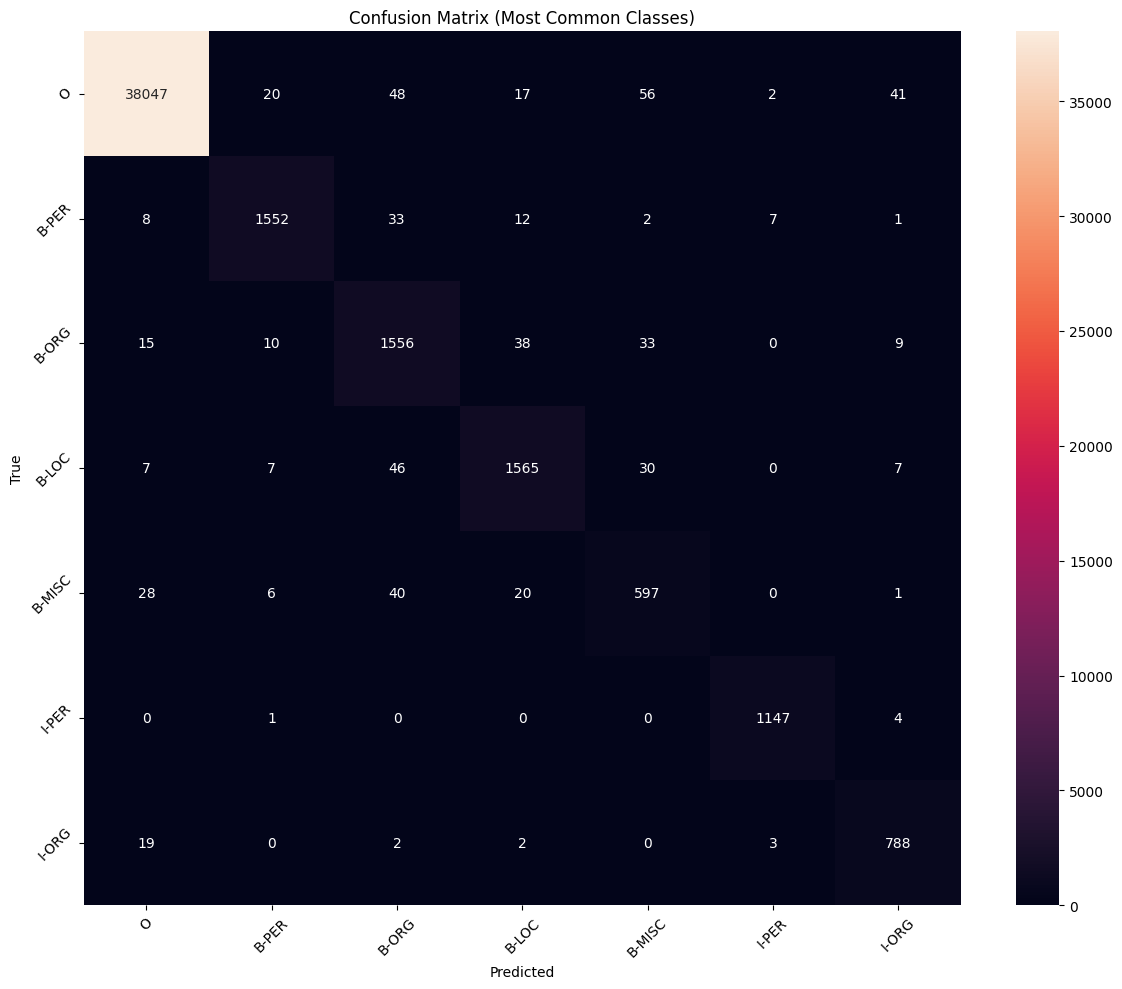

In [ ]:
# Create confusion matrix for the most common classes
most_common_labels = [label for label in label_list if not label.startswith('I-')] + ['I-PER', 'I-ORG']
label_to_idx = {label: idx for idx, label in enumerate(most_common_labels)}

confusion_matrix = np.zeros((len(most_common_labels), len(most_common_labels)))
for (true, pred), count in error_types.items():
    if true in most_common_labels and pred in most_common_labels:
        confusion_matrix[label_to_idx[true], label_to_idx[pred]] += count

# Add correct predictions to diagonal
for pred_batch, true_batch in zip(test_predictions, test_true_labels):
    for pred, true in zip(pred_batch, true_batch):
        if pred == true and pred in most_common_labels:
            confusion_matrix[label_to_idx[pred], label_to_idx[pred]] += 1

# Plot confusion matrix
plt.figure(figsize=(12, 10))
sns.heatmap(confusion_matrix, annot=True, fmt='.0f',
            xticklabels=most_common_labels,
            yticklabels=most_common_labels)
plt.title('Confusion Matrix (Most Common Classes)')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Print examples of specific error patterns
# Example: "O" predicted as an entity
print("\nExamples of tokens predicted as entities but are not:")
o_as_entity = [(true, pred) for (true, pred) in error_types.keys()
               if true == 'O' and pred != 'O']

for error_type in o_as_entity[:3]:
    true, pred = error_type
    tokens = error_tokens[error_type][:5]
    print(f"TRUE: {true} -> PRED: {pred}:")
    print(f"  Tokens: {', '.join(tokens)}")

# Example: Entity predicted as "O"
print("\nExamples of entities missed (predicted as 'O'):")
entity_as_o = [(true, pred) for (true, pred) in error_types.keys()
               if true != 'O' and pred == 'O']

for error_type in entity_as_o[:3]:
    true, pred = error_type
    tokens = error_tokens[error_type][:5]
    print(f"TRUE: {true} -> PRED: {pred}:")
    print(f"  Tokens: {', '.join(tokens)}")

# Example: Entity type confusion
print("\nExamples of entity type confusion:")
entity_confusion = [(true, pred) for (true, pred) in error_types.keys()
                    if true != 'O' and pred != 'O' and true != pred]

for error_type in entity_confusion[:3]:
    true, pred = error_type
    tokens = error_tokens[error_type][:5]
    print(f"TRUE: {true} -> PRED: {pred}:")
    print(f"  Tokens: {', '.join(tokens)}")


Examples of tokens predicted as entities but are not:
TRUE: O -> PRED: B-LOC:
  Tokens: L, GO, West, East, MI
TRUE: O -> PRED: B-MISC:
  Tokens: Group, AU, EA, NO, W
TRUE: O -> PRED: I-MISC:
  Tokens: C, G, C, TO, MI

Examples of entities missed (predicted as 'O'):
TRUE: B-LOC -> PRED: O:
  Tokens: IT, W, W, League, P
TRUE: B-MISC -> PRED: O:
  Tokens: 1995, W, F, C, S
TRUE: B-PER -> PRED: O:
  Tokens: CA, PA, H, W, AL

Examples of entity type confusion:
TRUE: B-LOC -> PRED: B-ORG:
  Tokens: J, J, MAC, Tasmania, Philadelphia
TRUE: B-PER -> PRED: B-ORG:
  Tokens: Bit, Bit, Bit, Bit, LA
TRUE: I-MISC -> PRED: B-MISC:
  Tokens: World, F, F, G, World


In [ ]:
# 8. Contextual Analysis
# =====================
print("\n==== Contextual Analysis ====")

# Pick a few misclassified examples to analyze in context
print("Analyzing misclassified examples in context:")

# Function to get a full sentence with highlighted errors
def get_context_example(example_idx):
    # Get the original example from the test set
    original_example = dataset["test"][example_idx]
    tokens = original_example["tokens"]
    original_tags = [label_list[tag] for tag in original_example["ner_tags"]]

    # Get model predictions
    inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt").to(device)
    with torch.no_grad():
        outputs = model(**inputs)

    # Get predicted tags
    predictions = torch.argmax(outputs.logits, dim=2)
    predicted_tags = []

    # Convert predictions to tags
    for i, token_id in enumerate(inputs.word_ids()):
        if token_id is not None:
            if i == 0 or token_id != inputs.word_ids()[i-1]:
                predicted_tags.append(label_list[predictions[0, i].item()])

    # Create formatted output
    formatted_output = []
    for token, true_tag, pred_tag in zip(tokens, original_tags, predicted_tags):
        if true_tag == pred_tag:
            formatted_output.append(f"{token}")
        else:
            formatted_output.append(f"[{token}|TRUE:{true_tag}|PRED:{pred_tag}]")

    return " ".join(formatted_output)

# Show a few examples
for i in range(min(3, len(test_set_indices))):
    print(f"\nExample {i+1}:")
    example_text = get_context_example(test_set_indices[i])
    print(example_text)


==== Contextual Analysis ====
Analyzing misclassified examples in context:

Example 1:
SOCCER - [JAPAN|TRUE:B-LOC|PRED:B-ORG] GET [LUCKY|TRUE:O|PRED:B-LOC] WIN , CHINA IN SURPRISE DEFEAT .

Example 2:
Japan began the defence of their Asian Cup title with a lucky 2-1 win against Syria in a [Group|TRUE:O|PRED:B-MISC] [C|TRUE:O|PRED:I-MISC] championship match on Friday .

Example 3:
Defender Hassan Abbas rose to intercept a long ball into the area in the 84th minute but only managed to divert it into the top corner of [Bitar|TRUE:B-PER|PRED:B-ORG] 's goal .


In [ ]:
# 6. Test Evaluation and Analysis
# ==============================
print("\n==== Test Evaluation and Analysis ====")
print("Evaluating on test set...")
test_results, test_predictions, test_true_labels = evaluate(test_dataloader, "Testing")

# Print overall metrics
print("\nTest Results:")
print(f"Accuracy: {test_results['overall_accuracy']:.4f}")
print(f"Precision: {test_results['overall_precision']:.4f}")
print(f"Recall: {test_results['overall_recall']:.4f}")
print(f"F1 Score: {test_results['overall_f1']:.4f}")

# Print per-entity metrics
print("\nPer-Entity Type Metrics:")
entity_results = {}
for key in sorted(test_results.keys()):
    if key not in ['overall_accuracy', 'overall_precision', 'overall_recall', 'overall_f1']:
        entity_results[key] = {
            'precision': test_results[key]['precision'],
            'recall': test_results[key]['recall'],
            'f1': test_results[key]['f1'],
            'number': test_results[key]['number']
        }
        print(f"{key}:")
        print(f" Precision: {test_results[key]['precision']:.4f}")
        print(f" Recall: {test_results[key]['recall']:.4f}")
        print(f" F1: {test_results[key]['f1']:.4f}")
        print(f" Support: {test_results[key]['number']} entities")

# 7. Inference Examples on Test Set
# ================================
print("\n==== Inference Examples on Test Set ====")

def analyze_prediction_example(tokens, true_labels, pred_labels):
    """Display detailed analysis of a prediction example"""
    print(f"Sentence: {' '.join(tokens)}")
    print("\nToken-level analysis:")
    print(f"{'Token':<15} | {'True Label':<10} | {'Predicted':<10} | {'Correct?':<10}")
    print("-" * 50)

    correct_count = 0
    for token, true_label, pred_label in zip(tokens, true_labels, pred_labels):
        is_correct = true_label == pred_label
        if is_correct:
            correct_count += 1
        print(f"{token:<15} | {true_label:<10} | {pred_label:<10} | {'✓' if is_correct else '✗'}")

    accuracy = correct_count / len(tokens)
    print(f"\nToken accuracy: {accuracy:.4f} ({correct_count}/{len(tokens)})")

    # Extract entities
    true_entities = extract_entities(tokens, true_labels)
    pred_entities = extract_entities(tokens, pred_labels)

    print("\nTrue entities:")
    if not any(true_entities.values()):
        print(" - No entities")
    else:
        for ent_type, ents in true_entities.items():
            for ent in ents:
                print(f" - {' '.join(ent)} ({ent_type})")

    print("\nPredicted entities:")
    if not any(pred_entities.values()):
        print(" - No entities")
    else:
        for ent_type, ents in pred_entities.items():
            for ent in ents:
                print(f" - {' '.join(ent)} ({ent_type})")

def extract_entities(tokens, tags):
    """Extract named entities from tokens and their corresponding tags"""
    entities = defaultdict(list)
    current_entity = []
    current_type = None

    for token, tag in zip(tokens, tags):
        if tag.startswith('B-'):
            # End previous entity if there was one
            if current_entity:
                entities[current_type].append(current_entity)
                current_entity = []
            # Start a new entity
            current_type = tag[2:]  # Remove the B- prefix
            current_entity = [token]
        elif tag.startswith('I-') and current_entity and tag[2:] == current_type:
            # Continue the current entity
            current_entity.append(token)
        else:  # O tag or broken I- tag
            # End previous entity if there was one
            if current_entity:
                entities[current_type].append(current_entity)
                current_entity = []
            current_type = None

    # Add the last entity if there is one
    if current_entity:
        entities[current_type].append(current_entity)

    return entities

def get_sample_examples(dataset, num_examples=5, seed=42):
    """Get sample examples to analyze"""
    # Set seed for reproducibility
    np.random.seed(seed)

    # Different sampling strategies
    examples = []

    # 1. Sample containing person entities
    person_examples = [i for i, example in enumerate(dataset)
                     if 'B-PER' in [label_list[tag] for tag in example["ner_tags"]]]
    if person_examples:
        examples.append(np.random.choice(person_examples))

    # 2. Sample containing organization entities
    org_examples = [i for i, example in enumerate(dataset)
                  if 'B-ORG' in [label_list[tag] for tag in example["ner_tags"]]]
    if org_examples:
        examples.append(np.random.choice(org_examples))

    # 3. Sample containing location entities
    loc_examples = [i for i, example in enumerate(dataset)
                  if 'B-LOC' in [label_list[tag] for tag in example["ner_tags"]]]
    if loc_examples:
        examples.append(np.random.choice(loc_examples))

    # 4. Sample with mixed entity types (at least 2 different types)
    mixed_examples = []
    for i, example in enumerate(dataset):
        tags = [label_list[tag] for tag in example["ner_tags"]]
        entity_types = set()
        for tag in tags:
            if tag.startswith('B-'):
                entity_types.add(tag[2:])
        if len(entity_types) >= 2:
            mixed_examples.append(i)

    if mixed_examples:
        examples.append(np.random.choice(mixed_examples))

    # 5. Random example (potentially with errors for error analysis)
    remaining_count = num_examples - len(examples)
    if remaining_count > 0:
        random_indices = np.random.choice(len(dataset), remaining_count, replace=False)
        examples.extend(random_indices)

    return examples[:num_examples]

def run_inference_examples(dataset, model, tokenizer, num_examples=5):
    """Run and analyze inference on selected examples from the dataset"""
    example_indices = get_sample_examples(dataset, num_examples)

    for i, idx in enumerate(example_indices):
        print(f"\n\n=== Example {i+1} (Dataset Index: {idx}) ===")
        # Convert idx to regular Python int
        idx = int(idx) # This line is added to convert numpy.int64 to int
        example = dataset[idx]
        tokens = example["tokens"]
        true_labels = [label_list[tag] for tag in example["ner_tags"]]

        # Get model predictions
        inputs = tokenizer(tokens, is_split_into_words=True, return_tensors="pt").to(device)
        with torch.no_grad():
            outputs = model(**inputs)
        predictions = torch.argmax(outputs.logits, dim=2).cpu().numpy()[0]

        # Map predictions back to original tokens
        predicted_labels = []
        word_ids = inputs.word_ids()
        previous_word_idx = None
        for i, word_idx in enumerate(word_ids):
            if word_idx is None or word_idx == previous_word_idx:
                continue
            predicted_labels.append(label_list[predictions[i]])
            previous_word_idx = word_idx

        # Ensure lengths match
        predicted_labels = predicted_labels[:len(tokens)]

        # Display detailed analysis
        analyze_prediction_example(tokens, true_labels, predicted_labels)

# Run inference examples on test set
print("Running inference on 5 examples from test set...")
run_inference_examples(dataset["test"], model, tokenizer, num_examples=5)

# Optional: Visualize entity distribution
def visualize_entity_distribution():
    """Visualize the distribution of entity types in test set"""
    import matplotlib.pyplot as plt

    entity_counts = {key: value['number'] for key, value in entity_results.items()}

    plt.figure(figsize=(10, 6))
    plt.bar(entity_counts.keys(), entity_counts.values())
    plt.title('Entity Type Distribution in Test Set')
    plt.xlabel('Entity Type')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig('entity_distribution.png')
    plt.show()

# Comment out if visualization not needed
# visualize_entity_distribution()

# Optional: Error analysis visualization
def visualize_error_analysis():
    """Visualize precision/recall for different entity types"""
    import matplotlib.pyplot as plt

    entity_types = list(entity_results.keys())
    precision = [entity_results[et]['precision'] for et in entity_types]
    recall = [entity_results[et]['recall'] for et in entity_types]
    f1 = [entity_results[et]['f1'] for et in entity_types]

    x = np.arange(len(entity_types))
    width = 0.25

    fig, ax = plt.subplots(figsize=(12, 7))
    ax.bar(x - width, precision, width, label='Precision')
    ax.bar(x, recall, width, label='Recall')
    ax.bar(x + width, f1, width, label='F1 Score')

    ax.set_title('Performance Metrics by Entity Type')
    ax.set_ylabel('Score')
    ax.set_xticks(x)
    ax.set_xticklabels(entity_types, rotation=45)
    ax.legend()
    ax.set_ylim(0, 1)

    plt.tight_layout()
    plt.savefig('entity_performance.png')
    plt.show()

# Comment out if visualization not needed
# visualize_error_analysis()

print("\nAnalysis complete!")


==== Test Evaluation and Analysis ====
Evaluating on test set...


Testing:   0%|          | 0/216 [00:00<?, ?it/s]


Test Results:
Accuracy: 0.9835
Precision: 0.9096
Recall: 0.9258
F1 Score: 0.9176

Per-Entity Type Metrics:
LOC:
 Precision: 0.9397
 Recall: 0.9358
 F1: 0.9377
 Support: 1666 entities
MISC:
 Precision: 0.7726
 Recall: 0.8276
 F1: 0.7992
 Support: 702 entities
ORG:
 Precision: 0.8847
 Recall: 0.9241
 F1: 0.9040
 Support: 1661 entities
PER:
 Precision: 0.9700
 Recall: 0.9598
 F1: 0.9648
 Support: 1615 entities

==== Inference Examples on Test Set ====
Running inference on 5 examples from test set...


=== Example 1 (Dataset Index: 2702) ===
Sentence: 8. Nikkola 101

Token-level analysis:
Token           | True Label | Predicted  | Correct?  
--------------------------------------------------
8.              | O          | O          | ✓
Nikkola         | B-PER      | B-PER      | ✓
101             | O          | O          | ✓

Token accuracy: 1.0000 (3/3)

True entities:
 - Nikkola (PER)

Predicted entities:
 - Nikkola (PER)


=== Example 2 (Dataset Index: 3308) ===
Sentence: New Jersey